Helper Functions

In [1]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
%matplotlib inline


def read_data(name, mode):
    '''
    read_data takes in a name of a csv file (without the ".csv" extension and the mode (test, train, or valid). Returns
    three numpy arrays: x_data, y_data, and labels.
    x_data: a numpy array of shape (n_samples, 3) where n_samples is the number of samples in the dataset. Index 0 is the
    bias term, and indexes 1 and 2 are the two input features.
    y_data: a numpy array of shape (n_samples, 1) where n_samples is the number of samples in the dataset. Index 0 is the
    output label.
    labels: a numpy array of shape (n_samples, 2) where n_samples is the number of samples in te dataset. Indexes 0 and 1
    are 1 depending on the output label. This is a one-hot encoded version of y_data.
    '''
    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root, name, mode)

    i = 0
    with open(filename, 'rt') as f:
        for line in f:
            line = line.replace('\n', '')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0, x1, x2])
                y_data.append([y])
                temp = [0, 0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data, dtype='float32')
    ys = np.array(y_data, dtype='float32')
    labels = np.array(label_data, dtype='float32')
    return (xs, ys, labels)


def compute_bounds(features):
    min1, max1 = features[:, 0].min() - 1, features[:, 0].max() + 1
    min2, max2 = features[:, 1].min() - 1, features[:, 1].max() + 1
    return (min1, max1, min2, max2)

Part 1

Best accuracy on test set for name = "xor" is with k = 7, and it reaches a value of 0.99



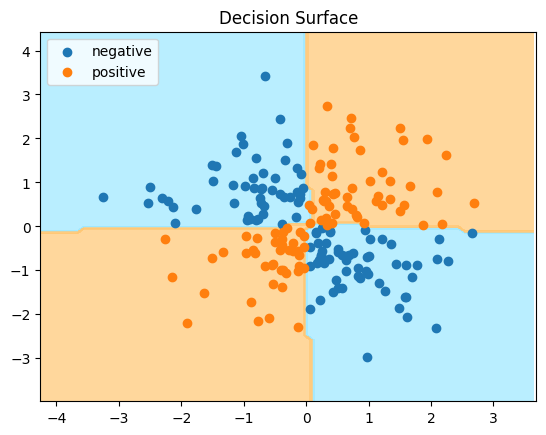

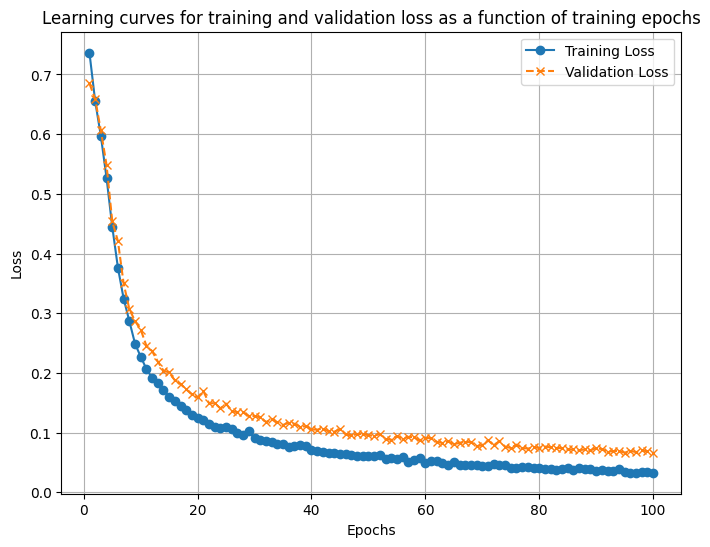






Best accuracy on test set for name = "two_gaussians" is with k = 2, and it reaches a value of 0.92



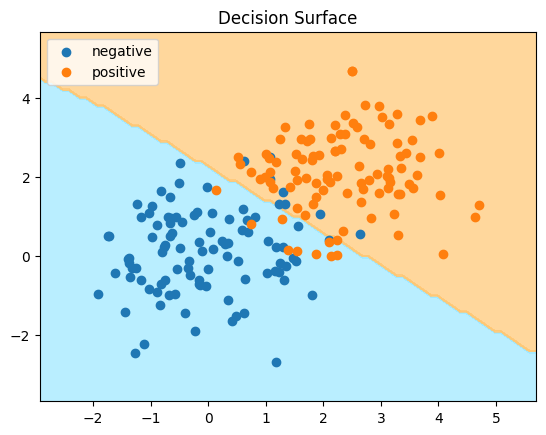

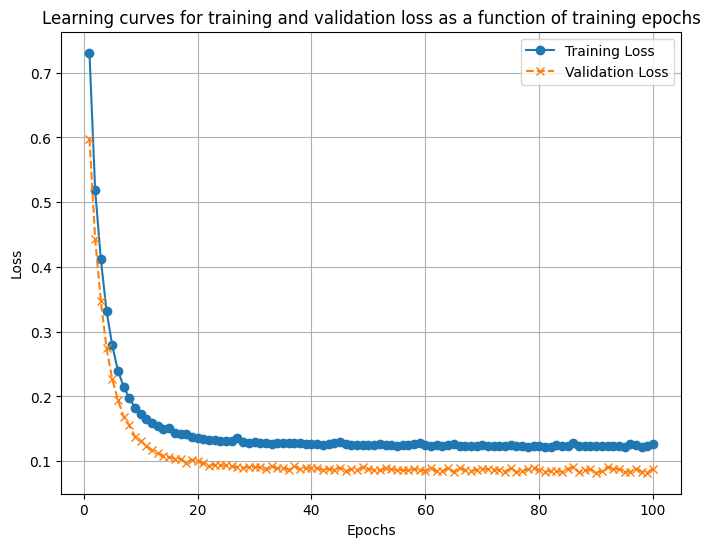






Best accuracy on test set for name = "spiral" is with k = 7, and it reaches a value of 0.99



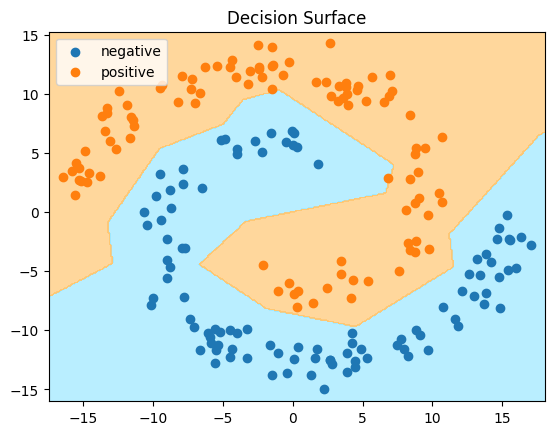

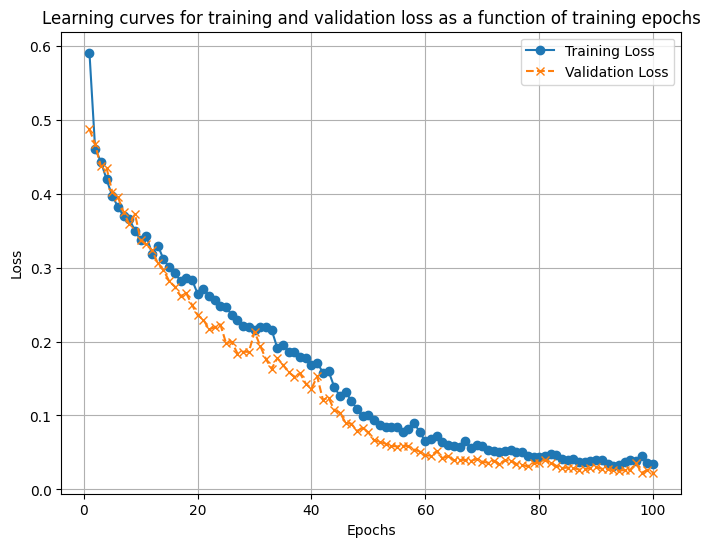






Best accuracy on test set for name = "center_surround" is with k = 3, and it reaches a value of 0.77



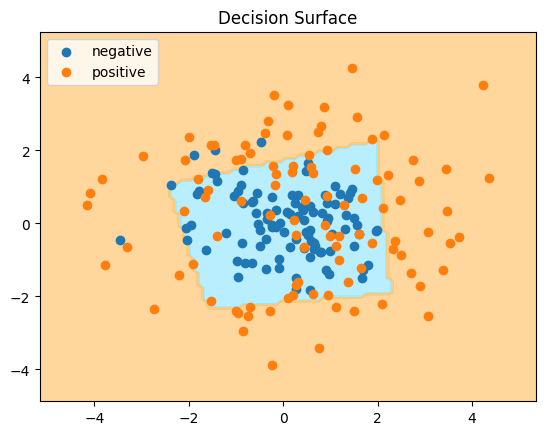

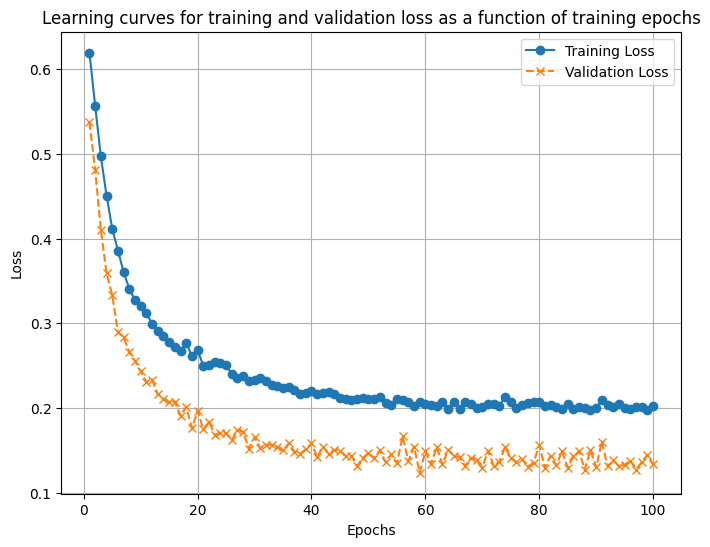

In [2]:
# set the device
device_part_1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a custom dataset class
class CustomDataset_part_1(torch.utils.data.Dataset):

    def __init__(self, name, mode):
        self.x_data, self.y_data, self.labels = read_data(name, mode)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_data[idx], dtype=torch.float32)
        y = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return x, y


# Define the neural network
class net3_part_1(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, activation):
        super(net3_part_1, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)  # input to hidden layer
        self.l2 = nn.Linear(hidden_size, output_size)  # hidden to output layer
        self.activation = activation  # define the activation function

    def forward(self, x):
        output = self.l1(x)
        output = self.activation(output)
        output = self.l2(output)
        #a = torch.mul(x[:,1],x[:,1])
        #b = torch.mul(x[:,2],x[:,2])
        #c = (a+b)/9.0
        #output = torch.exp(c)
        
        return output
    

# training function
def train_part_1(model, data_loader, loss_function, optimizer):

    model.train()
    train_loss = 0  # for plotting learning curves for training and validation loss as a function of training epochs

    for batch, (X, y) in enumerate(data_loader):
        
        X, y = X.to(device_part_1), y.to(device_part_1)
        pred = model(X)
        loss = loss_function(pred, y.squeeze().long())  # Originally y.unsqueeze(1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f"Pred: {pred[:5]}")
        #print(f"Y: {y[:5]}")
        #print(f"Loss: {loss.item()}")
        train_loss += loss.item()

    train_loss /= len(data_loader)
    return train_loss


# testing function
def test_part_1(model, data_loader, loss_function):

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device_part_1), y.to(device_part_1)
            pred = model(X)
            loss = loss_function(pred, y.squeeze().long()).item()  # Originally y.unsqueeze(1)
            test_loss += loss

    test_loss /= len(data_loader)
    return test_loss


# output the final accuracy of the model
def final_accuracy_part_1(model, data_loader):

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device_part_1), y.to(device_part_1)
            pred = model(X)
            pred = nn.functional.softmax(pred, dim=1)
            pred = torch.round(pred)
            if (pred[0,0] == 1 and y == 0) or (pred[0, 1] == 1 and y == 1):
                correct_predictions += 1
                
            total_predictions += y.size(0)

    return correct_predictions / total_predictions


def plot_training_and_validation_loss_part_1(train_loss, test_loss):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1,
                   len(train_loss) + 1),
             train_loss,
             label="Training Loss",
             marker='o')
    plt.plot(range(1,
                   len(test_loss) + 1),
             test_loss,
             label="Validation Loss",
             linestyle="--",
             marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(
        "Learning curves for training and validation loss as a function of training epochs"
    )
    plt.legend()
    plt.grid(True)
    plt.ion()
    plt.show()



def plot_decision_regions_part_1(features,
                          targets,
                          model,
                          axis=None,
                          transform=None,
                          bounds=None,
                          title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1, r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    grid = np.insert(grid, 0, 1.0, axis=1)

    # generate predictions over grid
    yhat = model(torch.from_numpy(grid).float()).detach().numpy()

    x = 0

    if yhat.shape[1] == 1: # XXX
        yhat = np.hstack((yhat, 1 - yhat))
        x = 1
    
    pred = np.argmax(yhat, axis=1)

    # reshape the predictions back into a grid
    zz = pred.reshape(xx.shape)

    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])

    if x == 1:
        binary_cmap = matplotlib.colors.ListedColormap(['#ffc773', '#9ce8ff'])

    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(features[row_idx_neg, 0],
                 features[row_idx_neg, 1],
                 label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(features[row_idx_pos, 0],
                 features[row_idx_pos, 1],
                 label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")


# hyperparameters
input_size = 3
output_size = 2
learning_rate = 0.01
num_epochs = 100
batch_size = 10

# Part 1
activation_function = nn.ReLU()
loss_function = nn.CrossEntropyLoss()

# Part 2
#activation_function = nn.Sigmoid()
#loss_function = nn.MSELoss()

# possible values
hidden_sizes = [2, 3, 5, 7, 9]
names = ['xor', 'two_gaussians', 'spiral', 'center_surround']

# to store best k and values for each dataset as well as losses
best_ks = [0, 0, 0, 0]
best_accs = [0, 0, 0, 0]
best_train_loss = [[], [], [], []]
best_valid_loss = [[], [], [], []]
best_models_1 = [[], [], [], []]

# iterate through each name and hidden size
for ii, name in enumerate(names):
    best_k = 0
    best_acc = 0

    for hidden_size in hidden_sizes:

        # initialize loss lists
        train_loss = []
        valid_loss = []

        # define the datasets and the loaders
        train_dataset = CustomDataset_part_1(name, 'train')
        valid_dataset = CustomDataset_part_1(name, 'valid')
        test_dataset = CustomDataset_part_1(name, 'test')

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, 1, shuffle=False)

        # build the model and optimizer
        model = net3_part_1(input_size, hidden_size, output_size, activation_function)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # train the model
        for epoch in range(num_epochs):
            train_losses = train_part_1(model, train_loader, loss_function, optimizer)
            valid_losses = test_part_1(model, valid_loader, loss_function)
            train_loss.append(train_losses)
            valid_loss.append(valid_losses)

        # Update best k/accuracy if needed
        final_acc = final_accuracy_part_1(model, test_loader)
        if final_acc > best_acc:
            best_acc = final_acc
            best_k = hidden_size

            best_accs[ii] = best_acc
            best_ks[ii] = best_k

            best_train_loss[ii] = train_loss
            best_valid_loss[ii] = valid_loss

            best_models_1[ii] = model

for ii, kk in enumerate(best_ks):

    print('Best accuracy on test set for name = "%s" is with k = %i, and it reaches a value of %.2f\n' % (names[ii], best_ks[ii], best_accs[ii]))

    x_vals, targets, _ = read_data(names[ii], 'test')
    features = np.array([inner_list[1:] for inner_list in x_vals])

    plot_decision_regions_part_1(features, targets, best_models_1[ii])

    # plot the train loss and test loss against the number of epochs in seperate graphs
    plot_training_and_validation_loss_part_1(best_train_loss[ii], best_valid_loss[ii])

    print("\n")

    print("\n\n")

Part 2

Best accuracy on test set for name = "xor" is with k = 9, and it reaches a value of 0.57



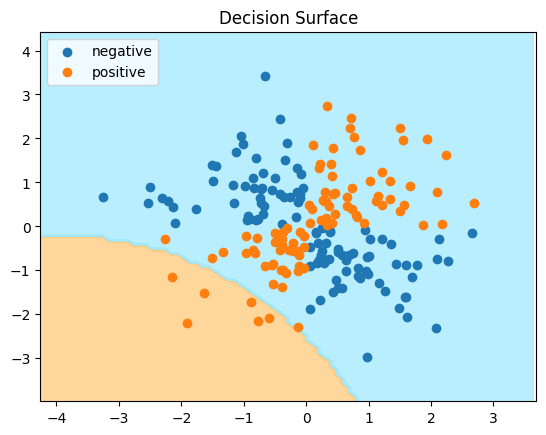

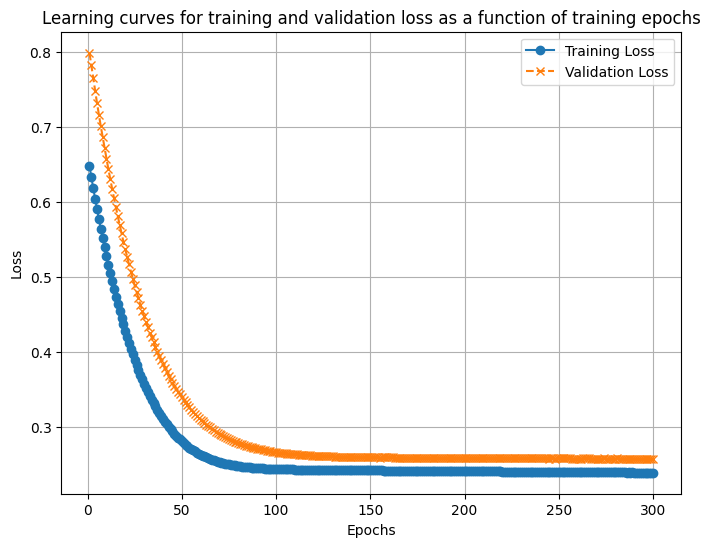






Best accuracy on test set for name = "two_gaussians" is with k = 3, and it reaches a value of 0.93



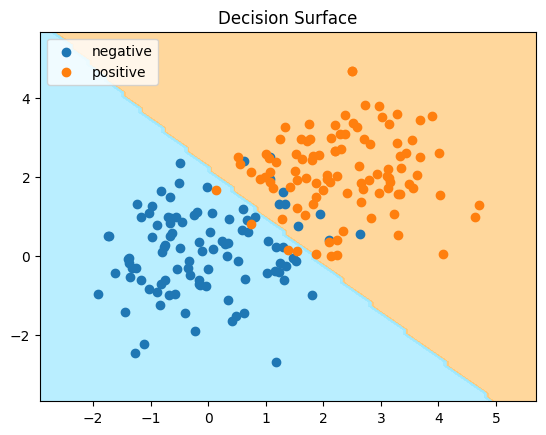

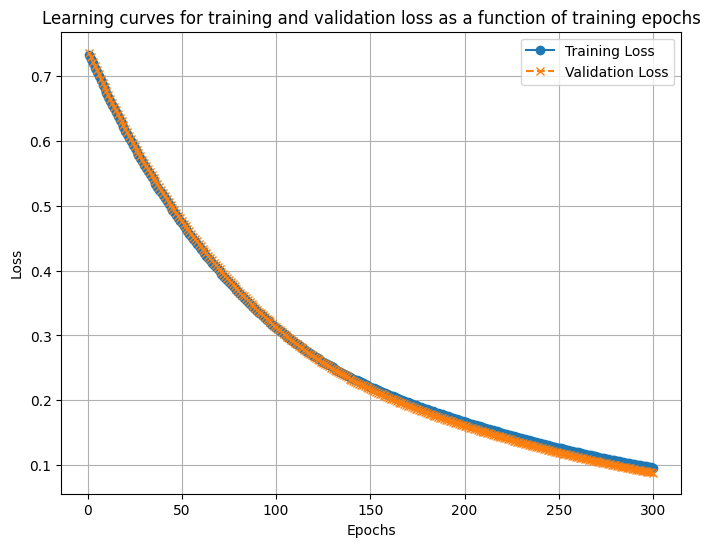






Best accuracy on test set for name = "spiral" is with k = 5, and it reaches a value of 0.81



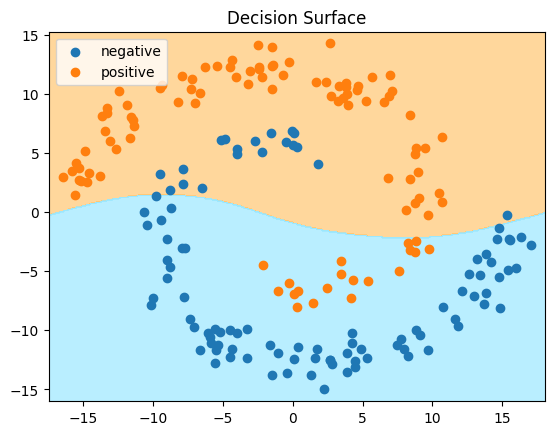

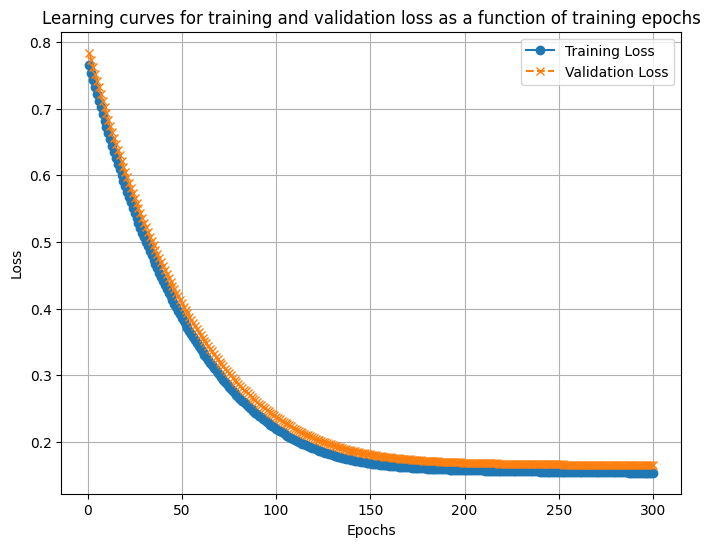






Best accuracy on test set for name = "center_surround" is with k = 7, and it reaches a value of 0.65



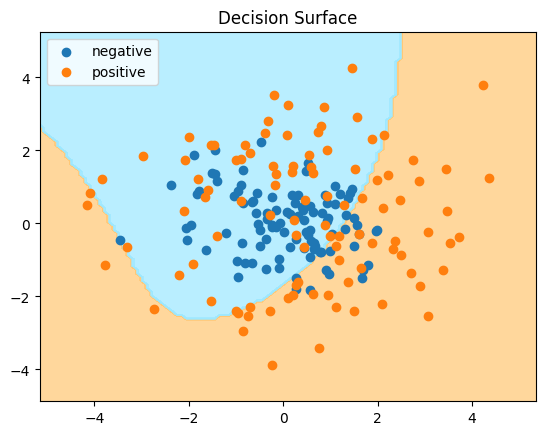

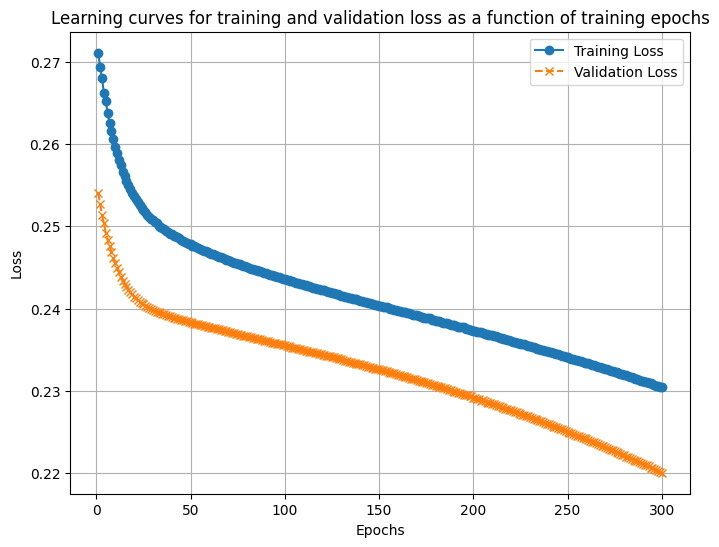

In [3]:
# training function
def train_part_2(model, data_loader, loss_function, optimizer):

    model.train()
    train_loss = 0  # for plotting learning curves for training and validation loss as a function of training epochs

    for batch, (X, y) in enumerate(data_loader):
        
        X, y = X.to(device_part_1), y.to(device_part_1)
        pred = model(X)
        loss = loss_function(pred, y.float())  # Originally y.squeeze().float()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f"Pred: {pred[:5]}")
        #print(f"Y: {y[:5]}")
        #print(f"Loss: {loss.item()}")
        train_loss += loss.item()

    train_loss /= len(data_loader)
    return train_loss


# testing function
def test_part_2(model, data_loader, loss_function):

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device_part_1), y.to(device_part_1)
            pred = model(X)
            loss = loss_function(pred, y.float()).item()  # Originally y.squeeze().float()
            test_loss += loss

    test_loss /= len(data_loader)
    return test_loss

# output the final accuracy of the model
def final_accuracy_part_2(model, data_loader):

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device_part_1), y.to(device_part_1)
            pred = model(X)
            pred = torch.round(pred)

            if pred == y:
                correct_predictions += 1
                
            total_predictions += y.size(0)

    return correct_predictions / total_predictions



# hyperparameters
input_size = 3
output_size = 1
learning_rate = 0.0001
num_epochs = 300
batch_size = 10

# Part 1
#activation_function = nn.ReLU()
#loss_function = nn.CrossEntropyLoss()

# Part 2
activation_function = nn.Sigmoid()
loss_function = nn.MSELoss()

# possible values
hidden_sizes = [2, 3, 5, 7, 9]
names = ['xor', 'two_gaussians', 'spiral', 'center_surround']

# to store best k and values for each dataset as well as losses
best_ks = [0, 0, 0, 0]
best_accs = [0, 0, 0, 0]
best_train_loss = [[], [], [], []]
best_valid_loss = [[], [], [], []]
best_models_2 = [[], [], [], []]

# iterate through each name and hidden size
for ii, name in enumerate(names):
    best_k = 0
    best_acc = 0

    for hidden_size in hidden_sizes:

        # initialize loss lists
        train_loss = []
        valid_loss = []

        # define the datasets and the loaders
        train_dataset = CustomDataset_part_1(name, 'train')
        valid_dataset = CustomDataset_part_1(name, 'valid')
        test_dataset = CustomDataset_part_1(name, 'test')

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, 1, shuffle=False)

        # build the model and optimizer
        model = net3_part_1(input_size, hidden_size, output_size, activation_function)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # train the model
        for epoch in range(num_epochs):
            train_losses = train_part_2(model, train_loader, loss_function, optimizer)
            valid_losses = test_part_2(model, valid_loader, loss_function)
            train_loss.append(train_losses)
            valid_loss.append(valid_losses)

        # Update best k/accuracy if needed
        final_acc = final_accuracy_part_2(model, test_loader)
        if final_acc > best_acc:
            best_acc = final_acc
            best_k = hidden_size

            best_accs[ii] = best_acc
            best_ks[ii] = best_k

            best_train_loss[ii] = train_loss
            best_valid_loss[ii] = valid_loss

            best_models_2[ii] = model


for ii, kk in enumerate(best_ks):

    print('Best accuracy on test set for name = "%s" is with k = %i, and it reaches a value of %.2f\n' % (names[ii], best_ks[ii], best_accs[ii]))

    x_vals, targets, _ = read_data(names[ii], 'test')
    features = np.array([inner_list[1:] for inner_list in x_vals])

    plot_decision_regions_part_1(features, targets, best_models_2[ii])

    # plot the train loss and test loss against the number of epochs in seperate graphs
    plot_training_and_validation_loss_part_1(best_train_loss[ii], best_valid_loss[ii])

    print("\n")

    print("\n\n")

Part 3

Final accuracy on test set (name = xor, k = 5): 0.83


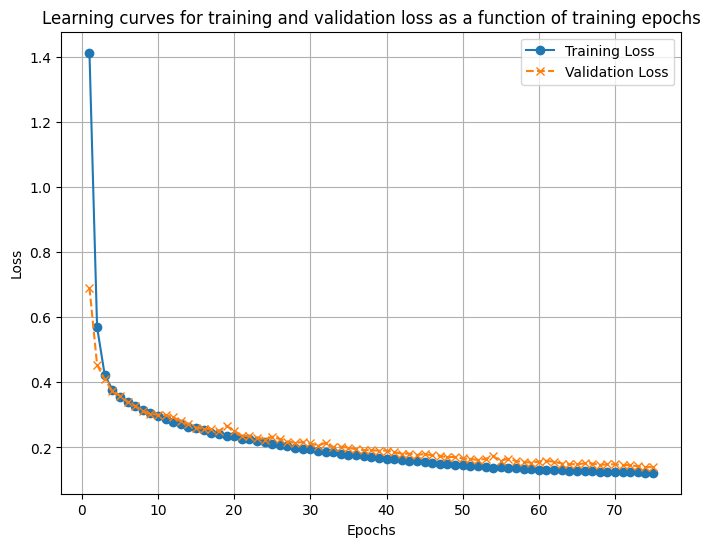

Final accuracy on test set (name = two_gaussians, k = 3): 0.83


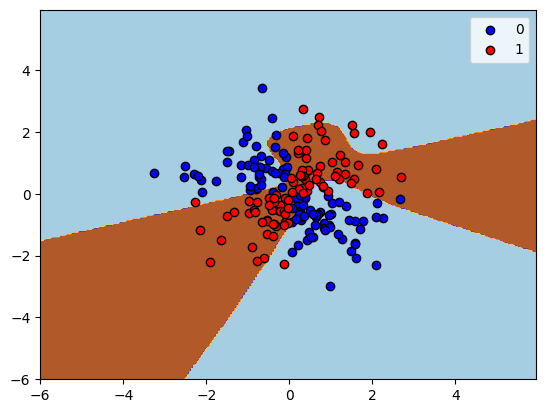

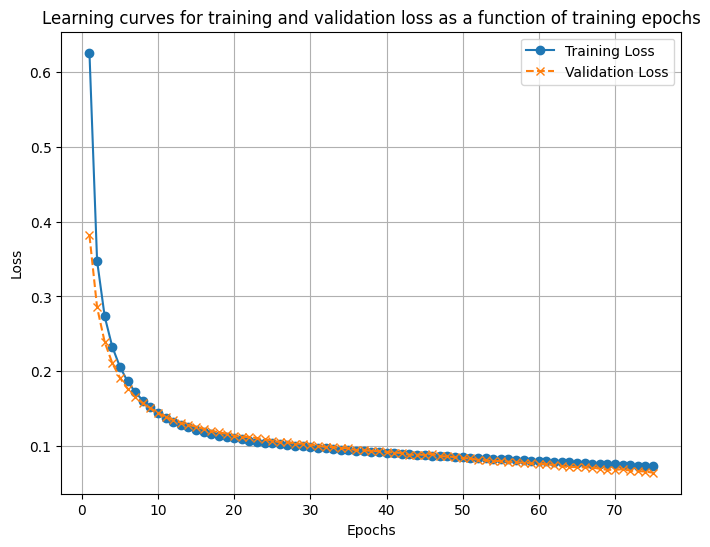

Final accuracy on test set (name = spiral, k = 3): 0.88


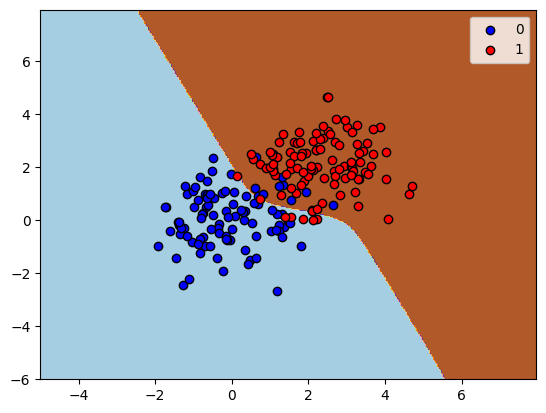

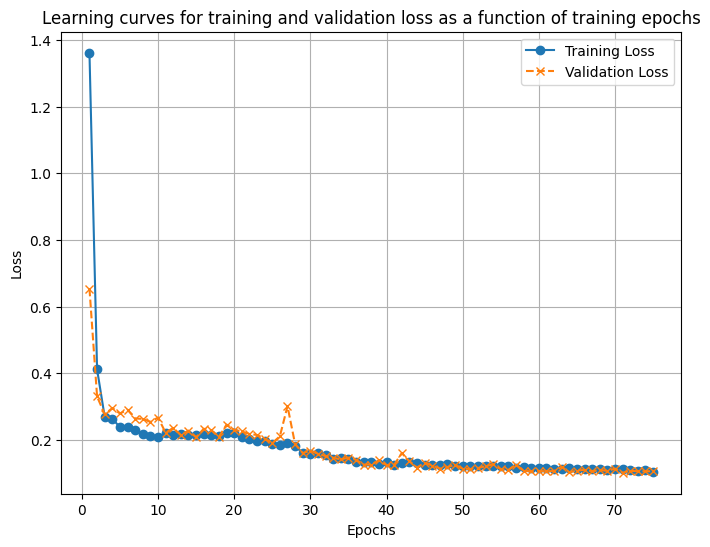

Final accuracy on test set (name = center_surround, k = 3): 0.69


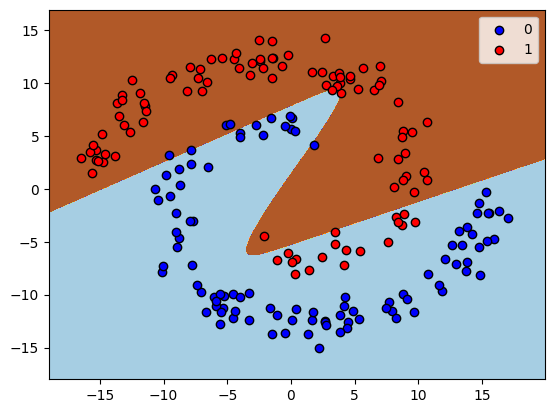

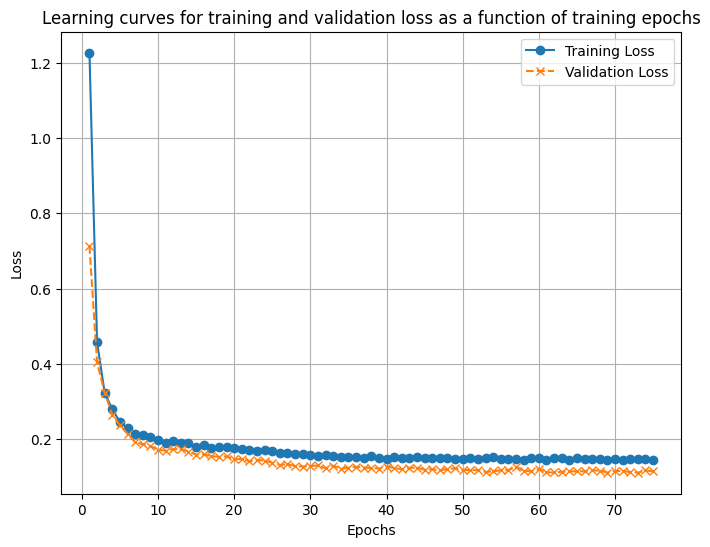

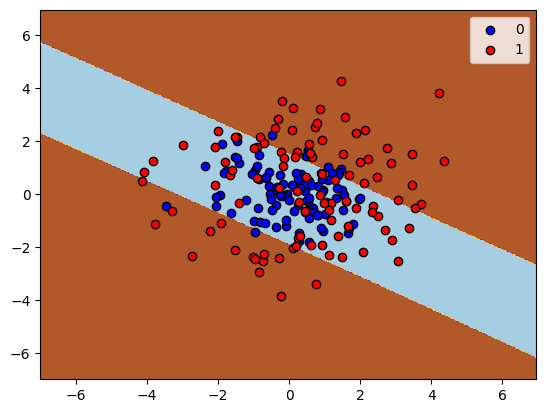

In [4]:

def plot_training_and_validation_loss_part_3(train_loss, test_loss):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1,
                   len(train_loss) + 1),
             train_loss,
             label="Training Loss",
             marker='o')
    plt.plot(range(1,
                   len(test_loss) + 1),
             test_loss,
             label="Validation Loss",
             linestyle="--",
             marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(
        "Learning curves for training and validation loss as a function of training epochs"
    )
    plt.legend()
    plt.grid(True)
    plt.ion()
    plt.show()

def plot_decision_surface_manual_part_3(model=None,
                                axis_limits=(-5, 5, -5, 5),
                                ax: matplotlib.axes.Axes = None,
                                name="xor"):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later

    # Find the limits for the scatterplot
    x_test, label, _ = read_data(name, 'test')
    idx_1 = x_test[:, 1]
    idx_2 = x_test[:, 2]

    # Find min and max for each column
    min_x, max_x = idx_1.min(), idx_1.max()
    min_y, max_y = idx_2.min(), idx_2.max()

    min_x = round(min_x)
    max_x = round(max_x)
    min_y = round(min_y)
    max_y = round(max_y)

    # xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
    #                      np.arange(axis_limits[2], axis_limits[3], .05))
    xx, yy = np.meshgrid(np.arange(min_x - 3, max_x + 3, .05),
                         np.arange(min_y - 3, max_y + 3, .05))

    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    feed_data = np.hstack([np.ones((data.shape[0], 1)), data])
    predicted_labels = np.argmax(model.forward(feed_data), axis =1)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    plt.figure()

    contour = ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    # Plot examples and their actual labels
    xx_e, yy_e = x_test[:, 1], x_test[:, 2]
    class_0 = label[:, 0] == 0  # Boolean mask for class 0
    class_1 = label[:, 0] == 1  # Boolean mask for class 1

    # Scatter plot for class 0
    ax.scatter(xx_e[class_0], yy_e[class_0], color='blue', label='0', edgecolor='k')

    # Scatter plot for class 1
    ax.scatter(xx_e[class_1], yy_e[class_1], color='red', label='1', edgecolor='k')

    ax.legend()    

    if ax is None:
        plt.show()


# Part 3: Doing it all by hand and using numpy
class ManualNeuralNetwork():

    def __init__(self, input_size, hidden_size, output_size, activation, loss_function):

        # parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        self.loss_function = loss_function

        # initial biases and weights
        self.weight1 = np.random.randn(input_size, hidden_size)
        self.weight2 = np.random.randn(hidden_size, output_size)
        self.bias1 = np.zeros((1, hidden_size))
        self.bias2 = np.zeros((1, output_size))

        self.hidden_activation = None

    def forward(self, x):
        output1 = np.dot(x, self.weight1) + self.bias1
        self.hidden_activation = self.activation(output1)
        output2 = np.dot(self.hidden_activation, self.weight2) + self.bias2
        return output2

    def backward(self, x, y_true, y_pred, learning_rate):

        # Find the gradient of the loss function based on our predictions
        loss_gradient = self.loss_function(y_true, y_pred, derivative=True) # (batch_size, output_size)

        # Find the gradients for the output layer 
        d_weight2 = np.dot(self.hidden_activation.T, loss_gradient)  # Shape: (hidden_size, output_size)
        d_bias2 = np.sum(loss_gradient, axis=0, keepdims=True)     # Shape: (1, output_size)

        # Backpropagate the error to the hidden layer and find the gradients for the hidden layer
        hidden_error = np.dot(loss_gradient, self.weight2.T) * self.activation(self.hidden_activation, derivative=True)  # Shape:(batch_size, hidden_size)

        # Find the gradients for the input layer        
        d_weight1 = np.dot(x.T, hidden_error)  # Shape: (input_size, hidden_size)
        d_bias1 = np.sum(hidden_error, axis=0, keepdims=True)

        # Update the parameters
        self.weight2 -= learning_rate * d_weight2
        self.bias2 -= learning_rate * d_bias2
        self.weight1 -= learning_rate * d_weight1
        self.bias1 -= learning_rate * d_bias1

    def train_once(self, x, y_true, learning_rate):
        y_pred = self.forward(x)
        self.backward(x, y_true, y_pred, learning_rate)
        loss = self.loss_function(y_true, y_pred)
        return loss

    def train_all(self, dataset, learning_rate, batch_size):

        # Get training x and y values
        x_train, _, y_train_onehot = dataset

        # Initialize loss
        train_loss = 0

        # Shuffle the dataset to make sure we are not training on the same group of data each time
        indices = np.random.permutation(len(x_train))
        shuffled_x_train = x_train[indices]
        shuffled_y_train_onehot = y_train_onehot[indices]

        # Counter for iterations
        cnt = 0

        # Iterate over entire training set but in batches with size batch_size
        for idx in range(0, len(shuffled_x_train), batch_size):
            # Iterate the count
            cnt += 1
            # Get the batch of data
            x_batch, y_batch = shuffled_x_train[idx:idx + batch_size], shuffled_y_train_onehot[idx:idx + batch_size]
            # Train the model
            loss = self.train_once(x_batch, y_batch, learning_rate)
            # Update the loss
            train_loss += loss

        return train_loss / cnt

    def test(self, dataset):
        x_test, _, y_test_onehot = dataset
        y_pred = self.forward(x_test)
        return self.loss_function(y_test_onehot, y_pred)

    def final_accuracy(self, dataset):
        predictions = np.round(self.forward(dataset[0]))
        correct = np.sum(np.all(predictions == dataset[2], axis=1))
        return correct / len(predictions)

def tanh(x, derivative=False):
    if derivative:
        return 1 - np.tanh(x) ** 2
    return np.tanh(x)

def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def mse(y_true, y_pred, derivative=False):
    if derivative:
        return 2 * (y_pred - y_true) / y_true.shape[0]
    return np.mean((y_pred - y_true) ** 2)



np.random.seed(42)

# Required parameters
input_size = 3
output_size = 2
# Hyperparameters
activation = tanh
loss_function = mse
batch_size = 10
learning_rate = 0.01
num_epochs = 75
hidden_sizes = [2, 3, 5, 7, 9]

"""
We used tanh (hyberbolic tangent) and mse (mean squared error) as activation and loss functions, respectively. After
testing on different combinations of batch size, learning rate, and number of epochs, we found that the best combination
was with 10, 0.01, and 75, respectively.
Afterwards, we determined the optimal sizes of the hidden layer for each dataset were as follows:
1. xor: k=5
    Final Test Accuracy: 0.89
2. two_gaussians: k=3
    Final Test Accuracy: 0.91
3. spiral: k=3
    Final Test Accuracy: 0.88
4. center_surround: k=3
    Final Test Accuracy: 0.69
"""

# Files to read from
names = ['xor', 'two_gaussians', 'spiral', 'center_surround']

for name, hidden_size in [("xor", 5), ("two_gaussians", 3), ("spiral", 3), ("center_surround", 3)]:

    # initialize loss lists
    train_loss = []
    test_loss = []

    # define the datasets and the loaders
    train_dataset = read_data(name, 'train')
    valid_dataset = read_data(name, 'valid')
    test_dataset = read_data(name, 'test')

    model = ManualNeuralNetwork(input_size, hidden_size, output_size, activation, loss_function)

    # train the model
    for epoch in range(num_epochs):
        train_losses = model.train_all(train_dataset, learning_rate, batch_size)
        test_losses = model.test(valid_dataset)
        train_loss.append(train_losses)
        test_loss.append(test_losses)

    print('Final accuracy on test set (name = %s, k = %i): %.2f' % (name, hidden_size, model.final_accuracy(test_dataset)))
    plot_training_and_validation_loss_part_3(train_loss, test_loss) 
    plot_decision_surface_manual_part_3(model, name=name)
    input("Press enter to continue")

Part 4

Final accuracy on test set (name = center_surround, k = 5): 0.75


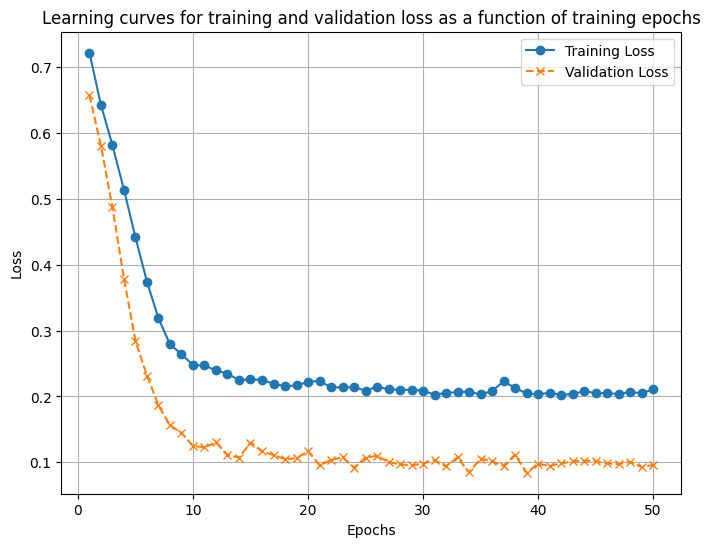

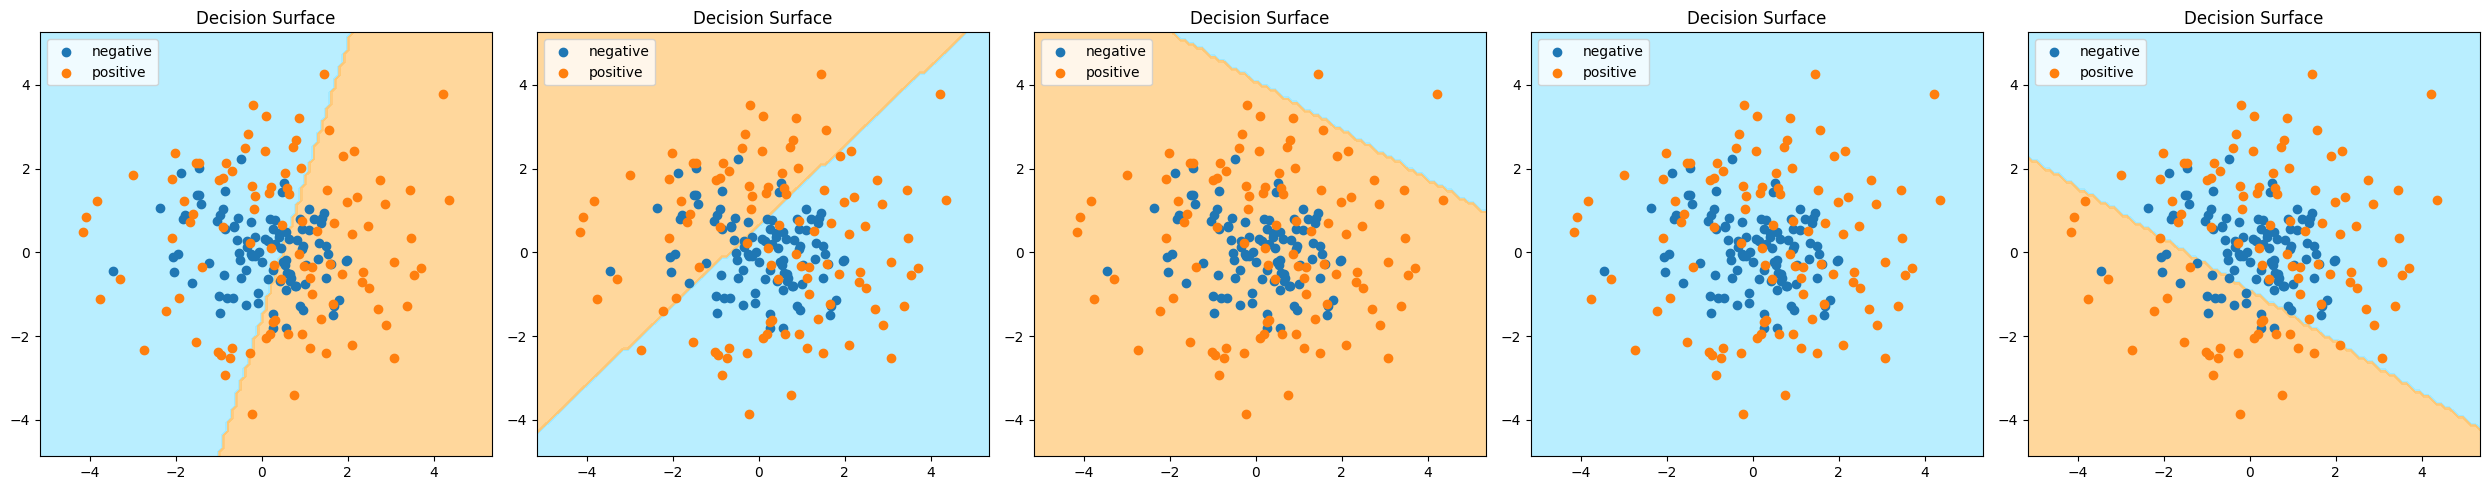

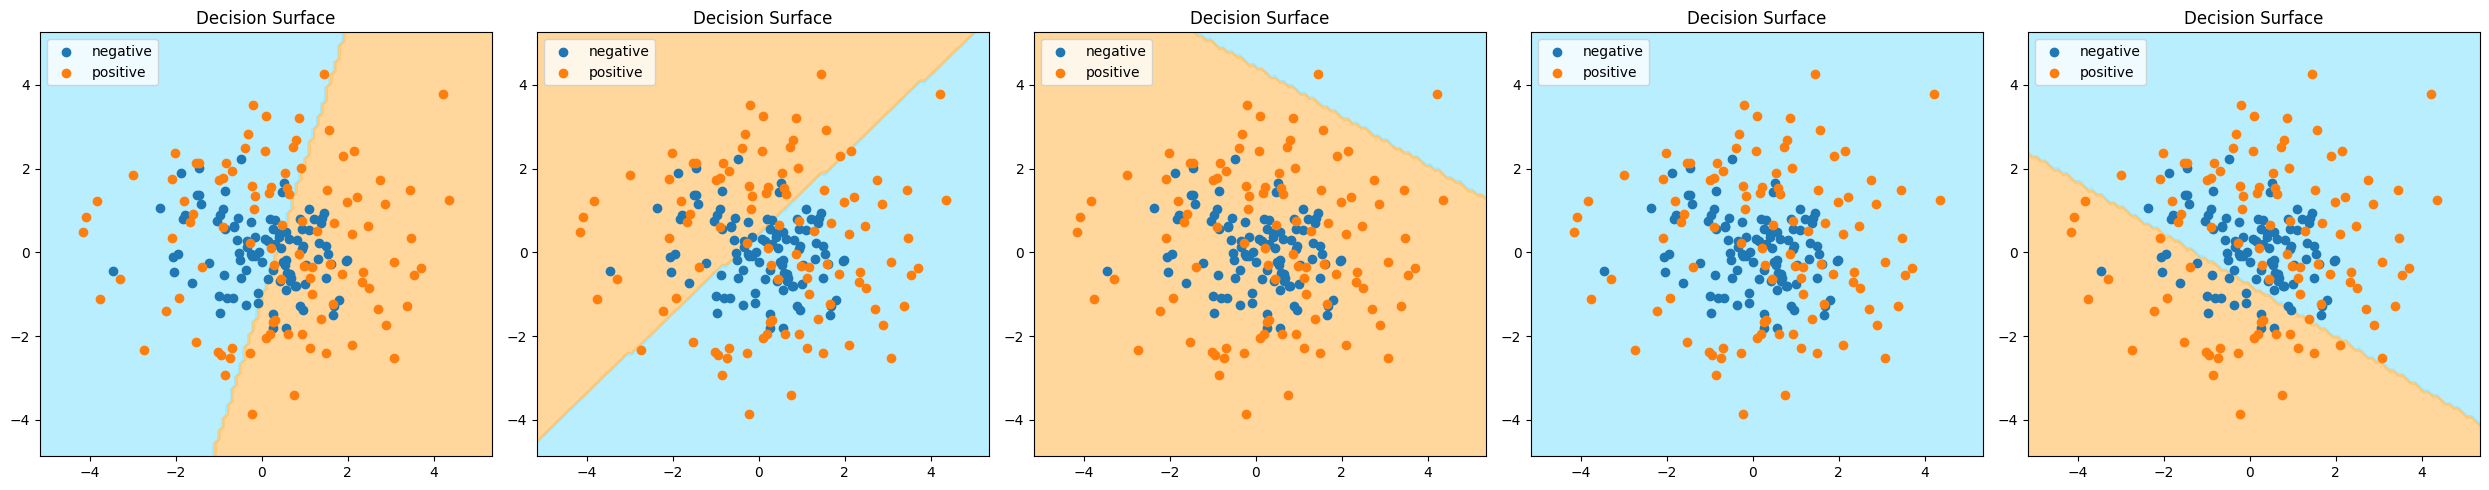

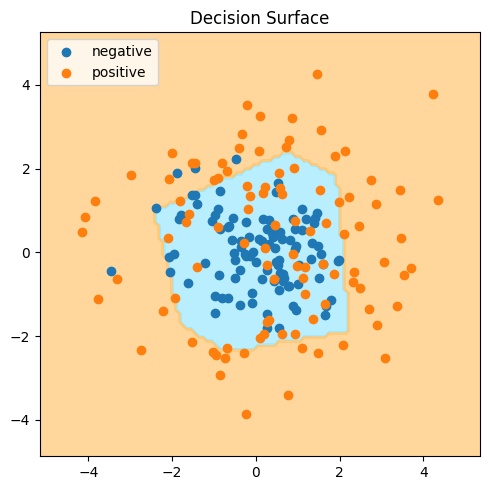

Final accuracy on test set (name = xor, k = 5): 0.75


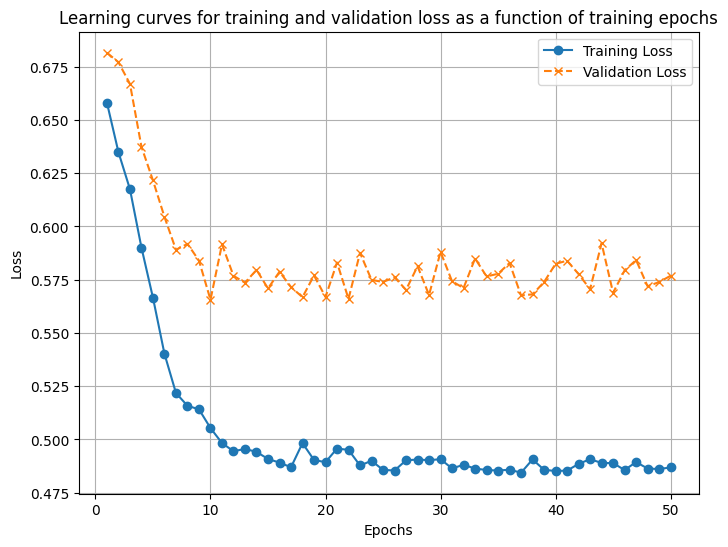

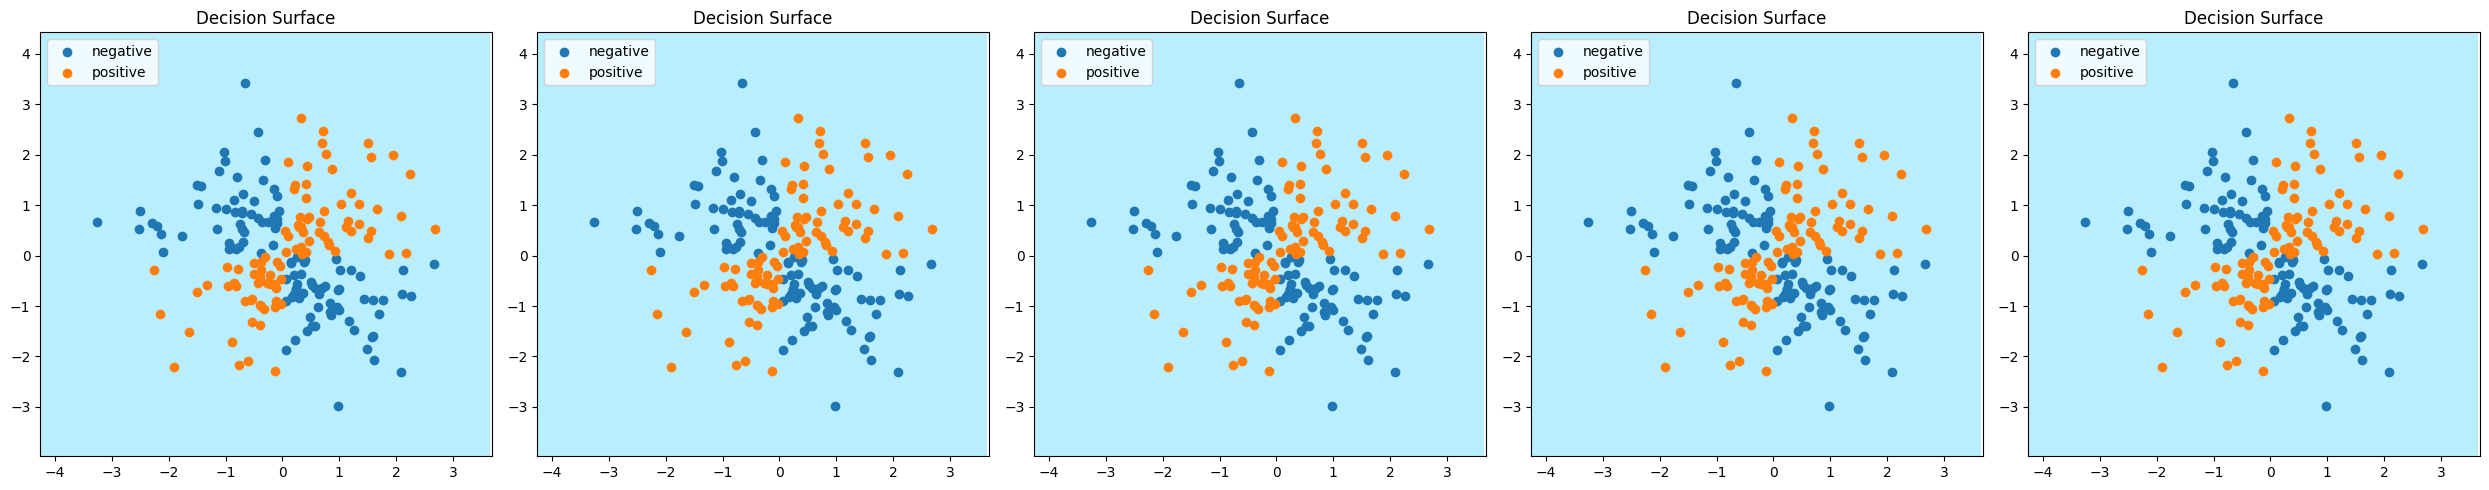

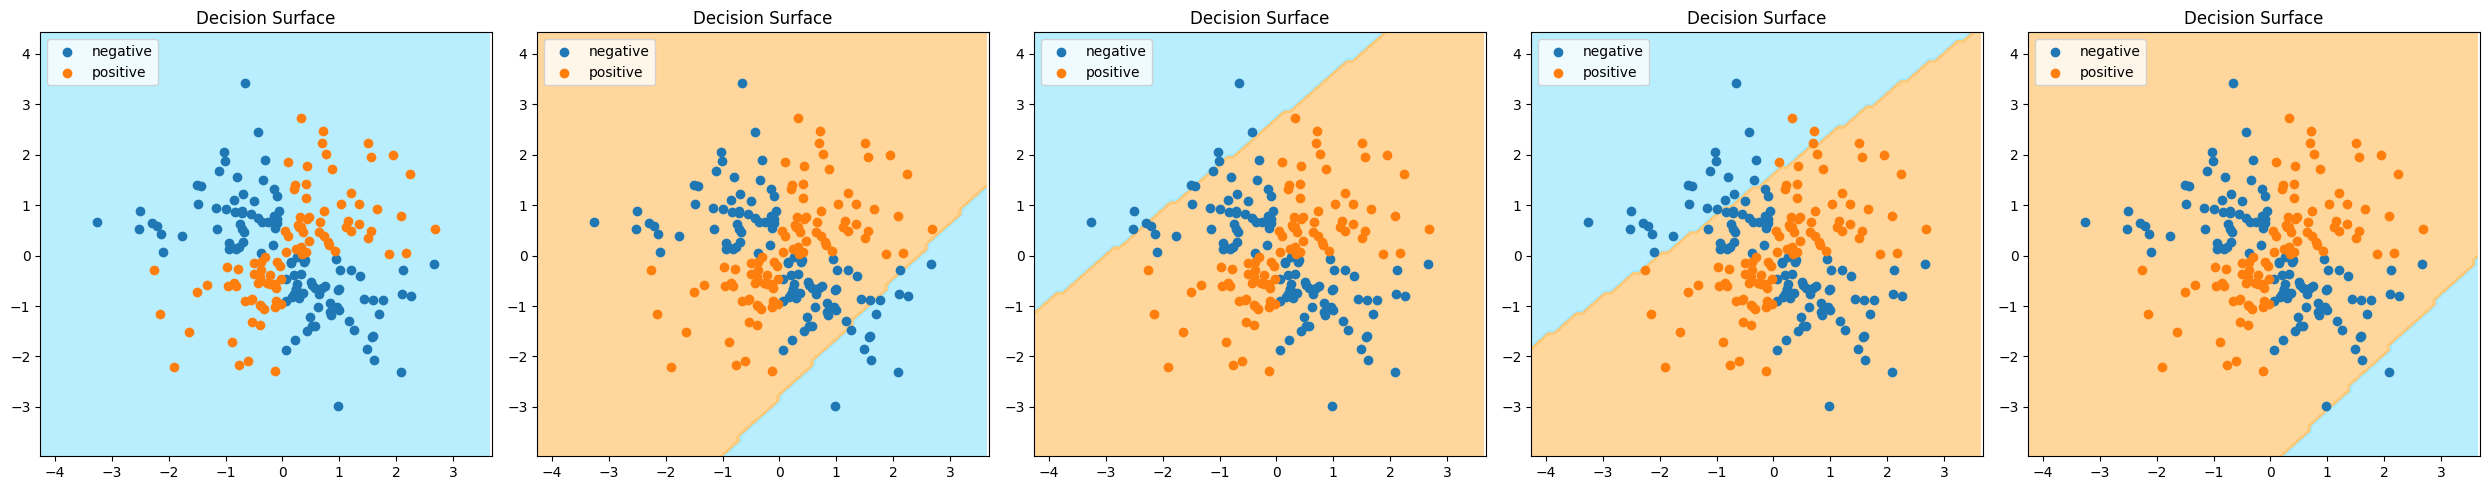

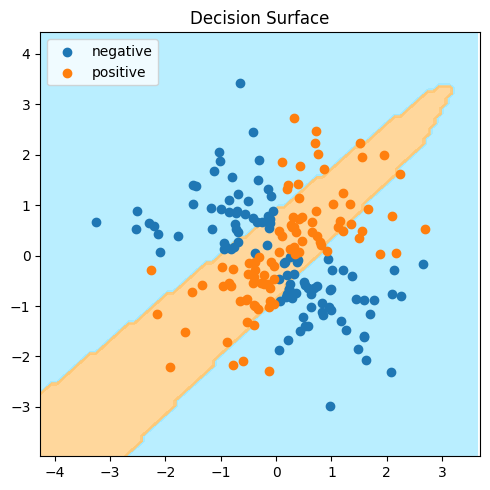

Final accuracy on test set (name = two_gaussians, k = 5): 0.92


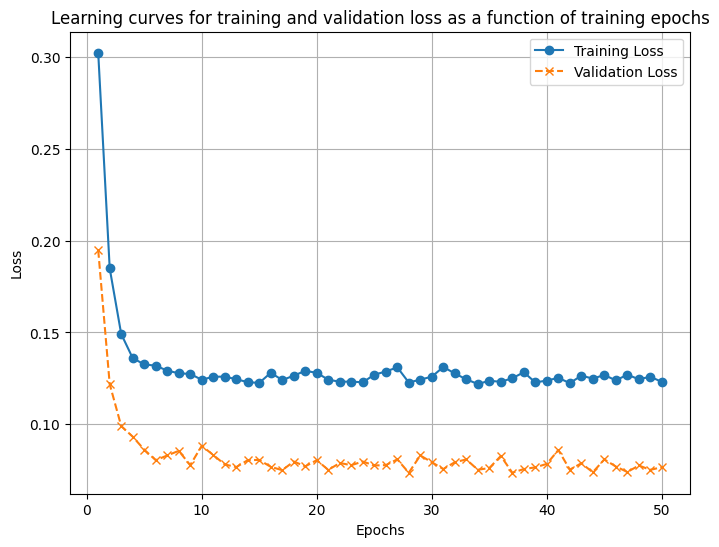

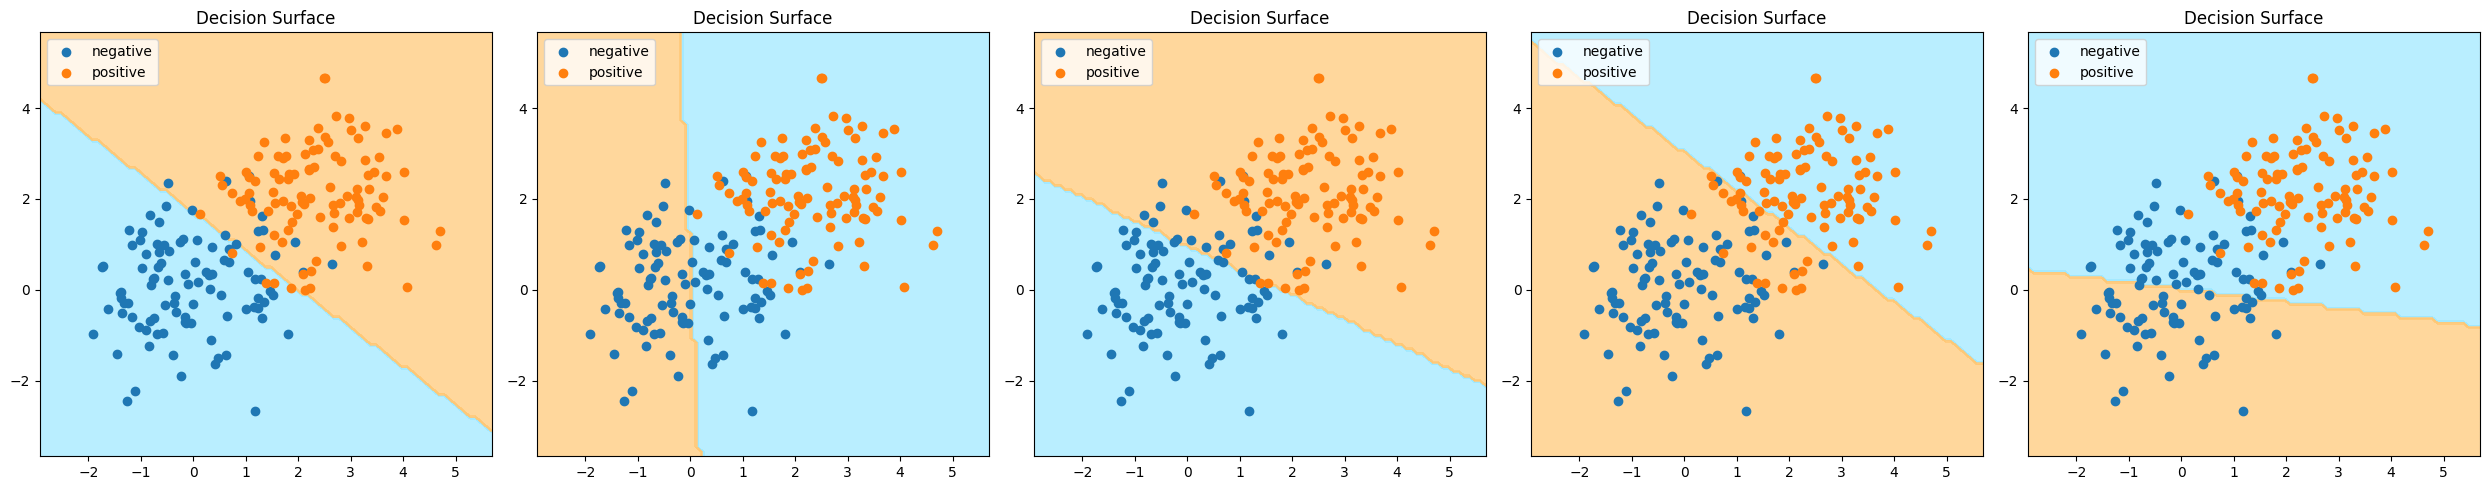

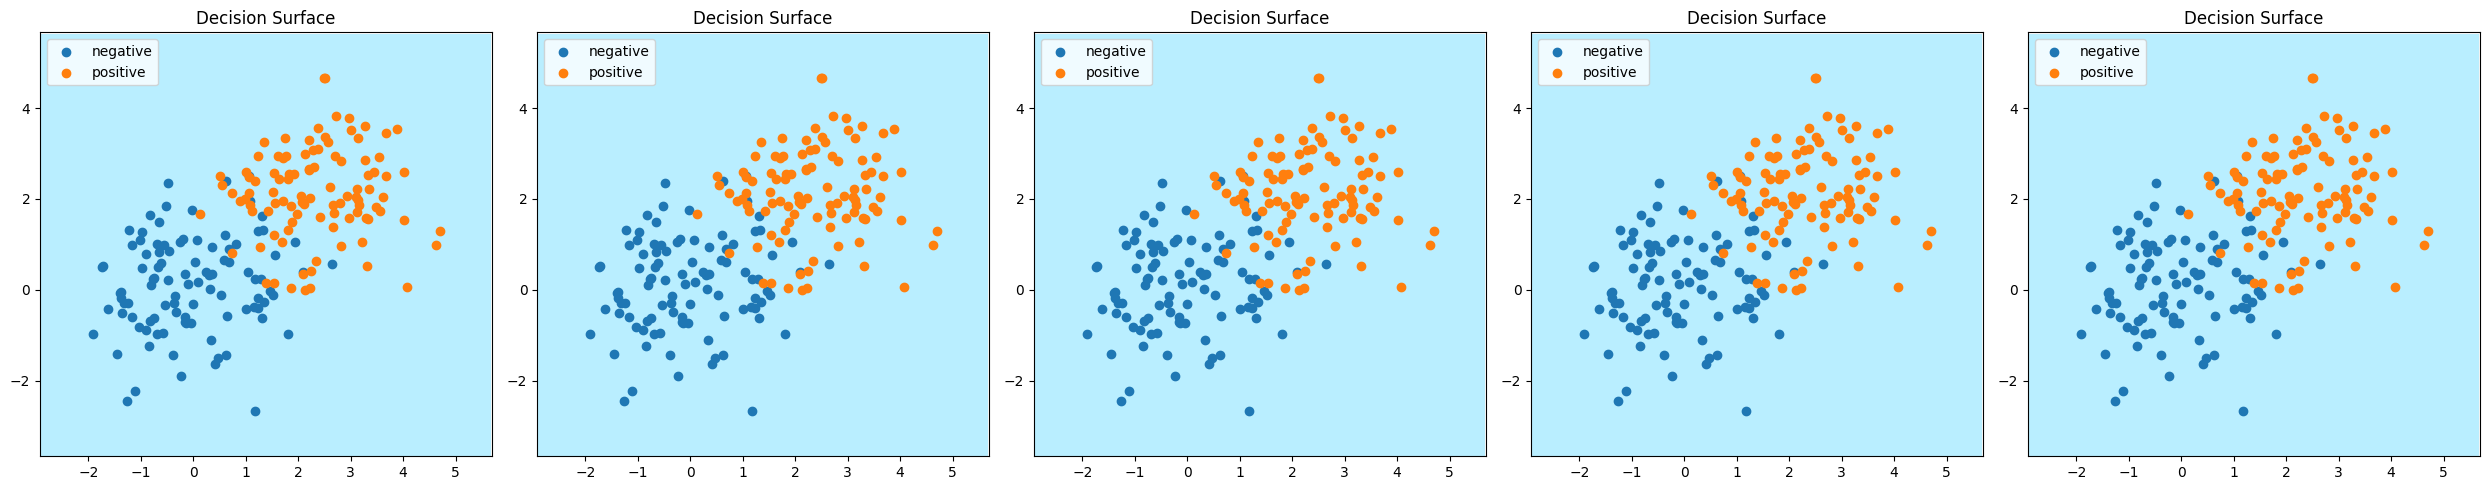

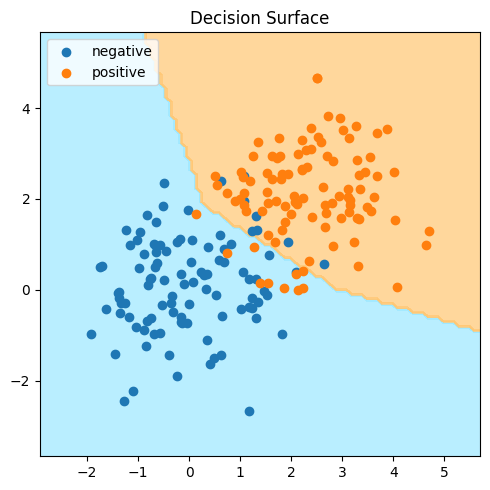

Final accuracy on test set (name = spiral, k = 7): 1.00


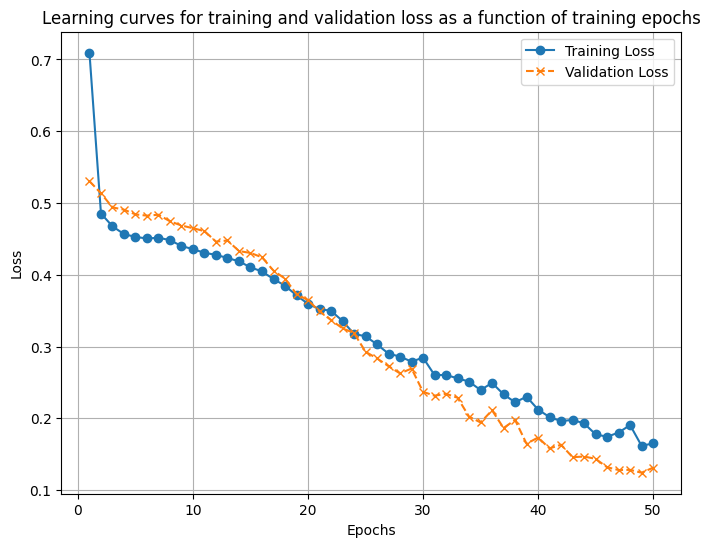

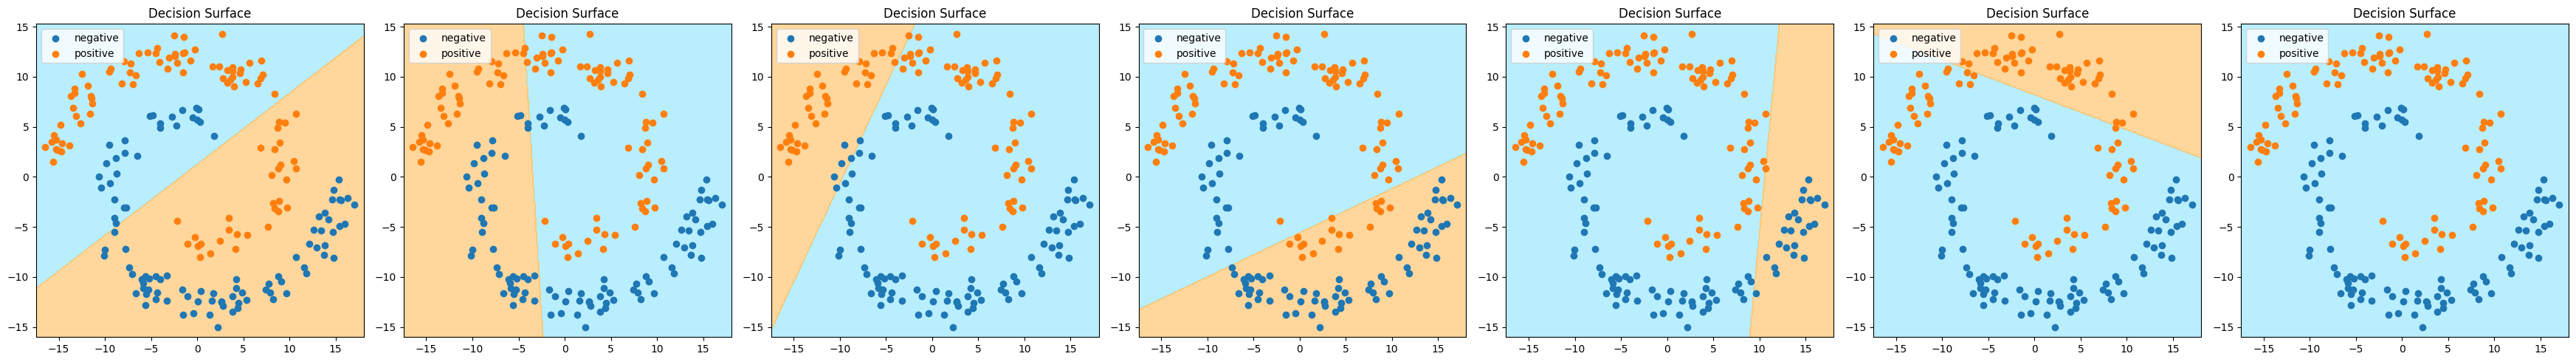

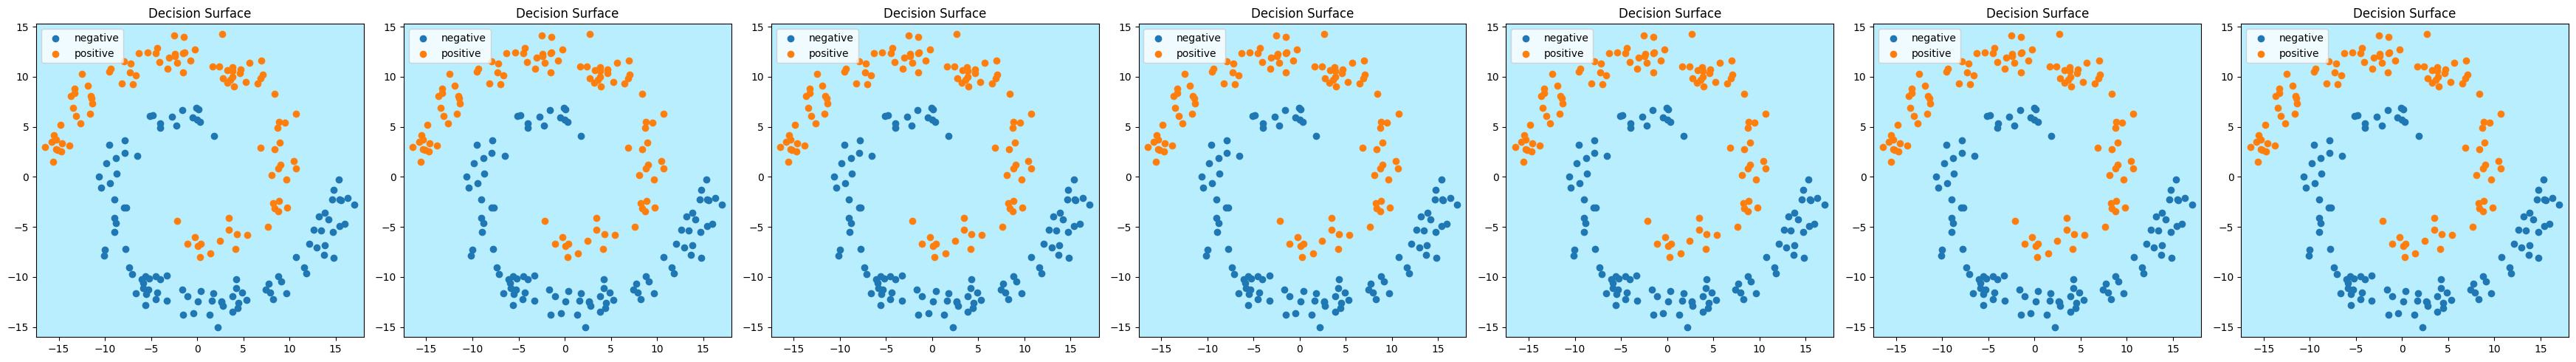

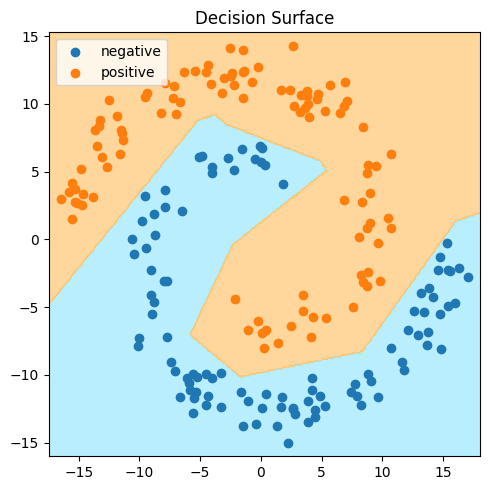

In [5]:
def plot_decision_regions_part_4(features,
                          targets,
                          model,
                          axis=None,
                          transform=None,
                          bounds=None,
                          title='Decision Surface',
                          node=False,
                          run=True):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1, r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    grid = np.insert(grid, 0, 1.0, axis=1)

    # generate predictions over grid
    if not node:
        num_hidden_nodes = 1
    else:
        num_hidden_nodes = model.l1.weight.shape[0]

    fig, axes = plt.subplots(1,
                             num_hidden_nodes,
                             figsize=(5 * num_hidden_nodes, 5))
    if num_hidden_nodes == 1:
        axes = [axes]

    for idx in range(num_hidden_nodes):

        if not node:
            yhat = [model(torch.from_numpy(grid).float()).detach().numpy()]
            pred = np.argmax(yhat[idx], axis=1)
        else:
            l1_result = model.l1(torch.from_numpy(grid).float())[:, idx]
            activation_result = model.activation(l1_result).unsqueeze(1)
            if run:
                activation_result_modified = torch.cat(
                    (torch.zeros(activation_result.size(0),
                                 num_hidden_nodes - 1), activation_result),
                    dim=1)
            else:
                activation_result_modified = torch.cat(
                    (activation_result,
                     torch.zeros(activation_result.size(0),
                                 num_hidden_nodes - 1)),
                    dim=1)

            # print(activation_result)
            yhat = model.l2(activation_result_modified).detach().numpy()
            # print(yhat)
            pred = np.argmax(yhat, axis=1)

        # reshape the predictions back into a grid
        zz = pred.reshape(xx.shape)

        # if axis is None:
        axis = axes[idx]

        # plot the grid of x, y and z values as a surface
        binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
        axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

        # plot "negative" class:
        row_idx_neg = np.where(targets < 0.5)[0]
        axis.scatter(features[row_idx_neg, 0],
                     features[row_idx_neg, 1],
                     label='negative')

        # plot "positive" class:
        row_idx_pos = np.where(targets > 0.5)[0]
        axis.scatter(features[row_idx_pos, 0],
                     features[row_idx_pos, 1],
                     label='positive')

        axis.set_title(title)
        axis.set_xlim(min1, max1)
        axis.set_ylim(min2, max2)

        axis.legend(loc="upper left")

    plt.tight_layout()
    plt.show()



# Define a custom dataset class
class CustomDataset_part_4(torch.utils.data.Dataset):

    def __init__(self, name, mode):
        self.x_data, self.y_data, self.labels = read_data(name, mode)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_data[idx], dtype=torch.float32)
        y = torch.tensor(self.y_data[idx], dtype=torch.float32)

        return x, y


# Define the neural network
class net3_part_4(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, activation):
        super(net3_part_4, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)  # input to hidden layer
        self.l2 = nn.Linear(hidden_size, output_size)  # hidden to output layer
        self.activation = activation  # define the activation function

    def forward(self, x):
        output = self.l1(x)
        output = self.activation(output)
        output = self.l2(output)
        return output


# training function
def train_part_4(model, data_loader, loss_function, optimizer):

    model.train()
    train_loss = 0  # for plotting learning curves for training and validation loss as a function of training epochs

    for batch, (X, y) in enumerate(data_loader):

        pred = model(X)
        loss = loss_function(pred,
                             y.squeeze().long())  # Originally y.unsqueeze(1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(data_loader)
    return train_loss


# testing function
def test_part_4(model, data_loader, loss_function):

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            loss = loss_function(
                pred,
                y.squeeze().long()).item()  # Originally y.unsqueeze(1)
            test_loss += loss

    test_loss /= len(data_loader)
    return test_loss


# output the final accuracy of the model
def final_accuracy_part_4(model, data_loader):

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            pred = torch.round(pred)
            pred_label = np.argmax(pred.numpy(), axis=1).astype(float)
            y_label = y.squeeze().numpy()
            for idx, _ in enumerate(pred_label):
                total_predictions += 1
                correct_predictions += (pred_label[idx] == y_label[idx])

    return correct_predictions / total_predictions


def plot_training_and_validation_loss_part_4(train_loss, test_loss):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1,
                   len(train_loss) + 1),
             train_loss,
             label="Training Loss",
             marker='o')
    plt.plot(range(1,
                   len(test_loss) + 1),
             test_loss,
             label="Validation Loss",
             linestyle="--",
             marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(
        "Learning curves for training and validation loss as a function of training epochs"
    )
    plt.legend()
    plt.grid(True)
    plt.ion()
    plt.show()




np.random.seed(42)
torch.manual_seed(0)

# hyperparameters
input_size = 3
output_size = 2
learning_rate = 0.01
num_epochs = 50
batch_size = 10
weight_decay = 0.001

# Part 1
activation_function = nn.ReLU()
loss_function = nn.CrossEntropyLoss()

# Part 2
# activation_function = nn.Sigmoid()
# loss_function = nn.MSELoss()

# possible values
hidden_sizes = [2, 3, 5, 7, 9]
names = ['xor', 'two_gaussians', 'spiral', 'center_surround']
"""
xor: k=9, 0.99
two_gaussians: k=7, 0.92
spiral: k=7, 1.00
center_surround: k=9, 0.74

"""

# iterate through each name and hidden size
for name, hidden_size in [("center_surround", 5), ("xor", 5), ("two_gaussians", 5), ("spiral", 7)]:

    # initialize loss lists
    train_loss = []
    test_loss = []

    # define the datasets and the loaders
    train_dataset = CustomDataset_part_4(name, 'train')
    valid_dataset = CustomDataset_part_4(name, 'valid')
    test_dataset = CustomDataset_part_4(name, 'test')
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=batch_size,
                                                shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                batch_size=batch_size,
                                                shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

    # build the model and optimizer
    model = net3_part_4(input_size, hidden_size, output_size, activation_function)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train the model
    for epoch in range(num_epochs):
        train_losses = train_part_4(model, train_loader, loss_function, optimizer)
        # print(train_losses)
        test_losses = test_part_4(model, valid_loader, loss_function)
        # Regularizer 1
        regularizer_1 = torch.norm(model.l1.weight,
                                    p=2).item() * weight_decay
        # Regularizer 2
        # https://paperswithcode.com/method/orthogonal-regularization
        WWT = torch.matmul(model.l1.weight.T, model.l1.weight)
        I = torch.eye(WWT.size(1))
        regularizer_2 = torch.norm(WWT - I, p="fro") * weight_decay
        train_loss.append((train_losses + regularizer_1 +
                            regularizer_2).detach().numpy())
        test_loss.append(test_losses)

    # show the final accuracy of the model
    print('Final accuracy on test set (name = %s, k = %i): %.2f' %
            (name, hidden_size, final_accuracy_part_4(model, test_loader)))

    # plot the train loss and test loss against the number of epochs in seperate graphs
    plot_training_and_validation_loss_part_4(train_loss, test_loss)

    x_vals, targets, _ = read_data(name, 'test')
    features = np.array([inner_list[1:] for inner_list in x_vals])

    plot_decision_regions_part_4(features, targets, model, node=True, run=False)
    plot_decision_regions_part_4(features, targets, model, node=True, run=True)
    plot_decision_regions_part_4(features, targets, model, node=False, run=False)

    input("Press enter to continue")